##Data loading

You can try your own after you train the JAX and PyTorch models with different batch sizes. I tried batch size = 32 and 64. Also, you must specify the paths that you save the iteration time log pickle files.

In [4]:
import pickle
import pandas as pd
import numpy as np

batch_sizes = [32, 64]
num_epochs = 300

df = []
df_iters = []
tasks = ['Train', 'Validate']
libraries = ['JAX', 'PyTorch']
ex_prod = [batch_sizes, tasks, libraries]
ex_index = pd.MultiIndex.from_product(ex_prod, names=['Batch size', 'Task', 'Library'])

for i, batch_size in enumerate(batch_sizes):
    jax_log_dir = '/content/drive/MyDrive/jax_exercise/output/Imagenette2/swint_jax_bs{}/iter_times.pkl'.format(batch_size)
    with open(jax_log_dir, 'rb') as fr:
        jax_log = pickle.load(fr)

    torch_log_dir = '/content/drive/MyDrive/jax_exercise/output/Imagenette2/swint_torch_bs{}/iter_times.pkl'.format(batch_size)
    with open(torch_log_dir, 'rb') as fr:
        torch_log = pickle.load(fr)

    niters_epoch_train = len(jax_log['train'])//num_epochs
    niters_epoch_valid = len(jax_log['valid'])//num_epochs

    df_train = pd.DataFrame(data=np.array([jax_log['train'], torch_log['train']]).T, 
                            columns=ex_index[4*i:4*i+2])
    df_valid = pd.DataFrame(data=np.array([jax_log['valid'], torch_log['valid']]).T, 
                            columns=ex_index[4*i+2:4*i+4])

    df_iter = pd.concat([df_train[:niters_epoch_train*5], df_valid[:niters_epoch_valid*5]], axis=1)
    df_iters.append(df_iter)
    df_train = df_train.groupby(df_train.index//niters_epoch_train).sum()
    df_valid = df_valid.groupby(df_valid.index//niters_epoch_valid).sum()
    df_batch = pd.concat([df_train, df_valid], axis=1)
    df.append(df_batch)

df = pd.concat(df, axis=1)
df_iters = pd.concat(df_iters, axis=1)

##Visualize training & validation speed per epoch
Tested batch size = 32 & 64 cases.

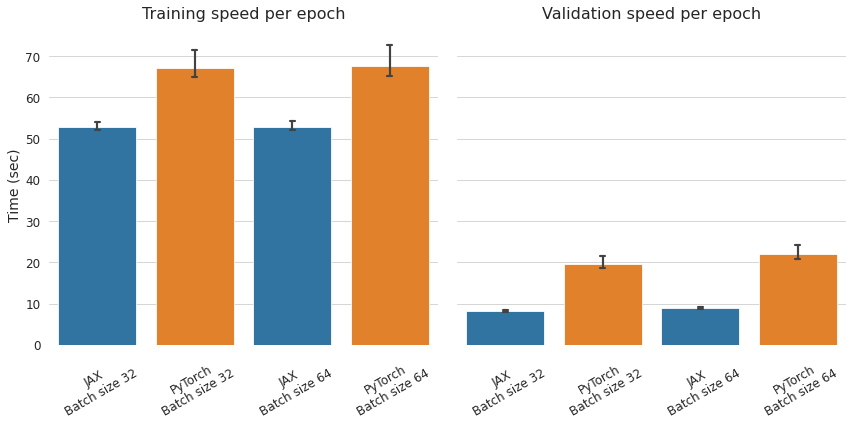

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

max_time_line = df.max().max()+10
max_time_bar = df.mean().max()+df.std().max()//num_epochs+10

sns.set_style("darkgrid")
sns.set_context("paper", rc={'xtick.labelsize':12,
                             'ytick.labelsize':12,
                             'axes.titlesize':16,
                             'axes.labelsize':14})  

fig = plt.figure(figsize=(12,6))

batch_size = 32

df = df.reorder_levels(['Task','Batch size','Library'], axis=1)

sns.set_style("whitegrid")

x_tick_labels = [library+'\n'+'Batch size {}'.format(batch_size) for batch_size in batch_sizes for library in libraries]
colors = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']

ax = fig.add_subplot(121)
ax.set_ylabel('Time (sec)')
ax.set_ylim([0, max_time_bar])
ax.set_title('Training speed per epoch')
sns.barplot(data=df['Train'], capsize=.05, palette=colors)
ax.set_xticklabels(x_tick_labels, rotation=30)
ax.set_ylim([0, max_time_bar])
sns.despine(left=True, bottom=True)

ax = fig.add_subplot(122)
ax.yaxis.set_ticklabels([])
ax.set_title('Validation speed per epoch')
sns.barplot(data=df['Validate'], capsize=.05, palette=colors)
ax.set_xticklabels(x_tick_labels, rotation=30)
ax.set_ylim([0, max_time_bar])
sns.despine(left=True, bottom=True)

fig.tight_layout()

fig.savefig('/content/drive/MyDrive/jax_exercise/swin_transformer_jax/figures/epoch_speed.png')

##Iteration speed analysis during the first five epochs.
Generally, compares to JAX, PyTorch takes a lot longer time during the first epoch. I assume there are 7 steps during iteration time measuring:
1. Data loading
2. Sending image and labels to cuda (GPU memory allocation)
3. Model inference
4. Loss computation
5. Loss backward
6. Step optimizer
7. Step learning rate scheduler

What caused the bottleneck is one of the TODO list to figure out.


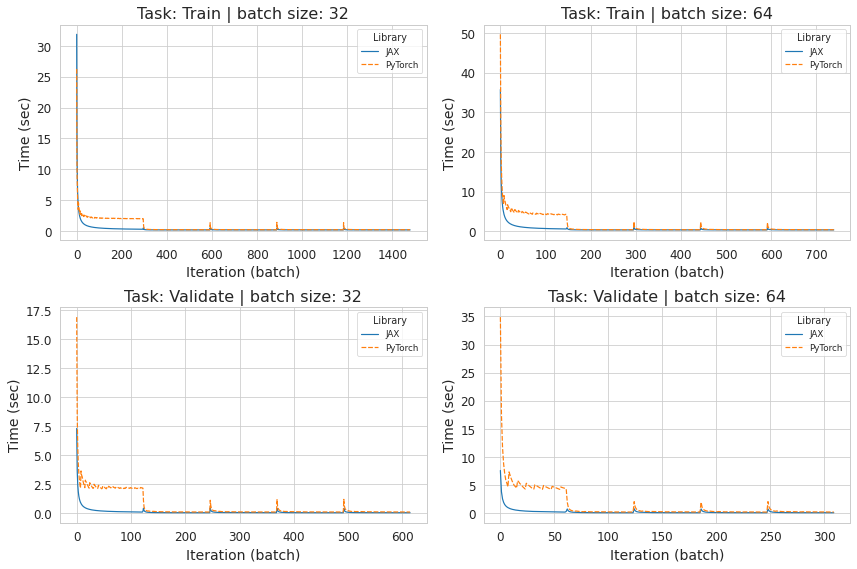

In [40]:
fig = plt.figure(figsize=(12,8))

for i, task in enumerate(tasks):
    for j, batch_size in enumerate(batch_sizes):
        ax = fig.add_subplot(2,2,2*i+j+1)
        ax.set_title('Task: {} | batch size: {}'.format(task, batch_size))
        ax.set_xlabel('Iteration (batch)')
        ax.set_ylabel('Time (sec)')
        sns.lineplot(data=df_iters[batch_size][task])
fig.tight_layout()
fig.savefig('/content/drive/MyDrive/jax_exercise/swin_transformer_jax/figures/five_epoch_speed.png')

## Percent speed difference analysis

In [36]:
print('Percent speed different including the first epoch.')
for task in tasks:
    for batch_size in batch_sizes:
        speed_diff = df.mean()[task][batch_size]['PyTorch']/df.mean()[task][batch_size]['JAX']-1
        print('Task: {} & batch size: {}: | JAX is {:.1f}% faster than PyTorch.'.format(task, batch_size, speed_diff*100))

print('\nPercent speed difference without the first epoch.')
for task in tasks:
    for batch_size in batch_sizes:
        speed_diff = df[1:].mean()[task][batch_size]['PyTorch']/df[1:].mean()[task][batch_size]['JAX']-1
        print('Task: {} & batch size: {}: | JAX is {:.1f}% faster than PyTorch.'.format(task, batch_size, speed_diff*100))        

Percent speed different including the first epoch.
Task: Train & batch size: 32: | JAX is 27.3% faster than PyTorch.
Task: Train & batch size: 64: | JAX is 28.0% faster than PyTorch.
Task: Validate & batch size: 32: | JAX is 140.5% faster than PyTorch.
Task: Validate & batch size: 64: | JAX is 147.4% faster than PyTorch.

Percent speed difference without the first epoch.
Task: Train & batch size: 32: | JAX is 24.9% faster than PyTorch.
Task: Train & batch size: 64: | JAX is 24.9% faster than PyTorch.
Task: Validate & batch size: 32: | JAX is 132.1% faster than PyTorch.
Task: Validate & batch size: 64: | JAX is 137.7% faster than PyTorch.
